# Environmental Crime
This workbook is a way to quickly view data from EPA's Enforcement and Compliance History Online portal that is relevant to your city. ECHO is the major repository of the U.S. Environmental Protection Agency for public data on its oversight and enforcement activities. It contains information on most if not all of the facilities regulated by the agency for their compliance with our major environmental laws. ([EPA’s “about ECHO data” page](https://echo.epa.gov/resources/echo-data/about-the-data))

The workbook shows you the cost, in dollar terms, of the climate change-causing greenhouse gases industries in your city are allowed to release, and whether enforcement actions are taken against facilities who violate the Clean Air Act.

## How to run this notebook:
1. Run the first cell and enter your own 5-digit U.S. ZIP code in the input field.
1. You can then run cells sequentially, or go to the Runtime menu and click "Run all": ![Screen Shot 2020-02-26 at 3 26 14 PM](https://user-images.githubusercontent.com/454690/75397703-60361e00-58ac-11ea-81c2-69d13dfce158.png)
1. That's it! It might take a minute or two to run and generate all the reports.

# **Let's begin**
Hover over the "[ ]" on the top left corner of the cell below and you should see a "play" button appear. Click on it to run the cell then move to the next one.¶
### Run this next cell to create the widget for inputting your zip code. It will create an input field at the bottom. Enter your city and state and then move on to the next cell, or choose Run All as described above.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import folium
import urllib.parse
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, HTML

def get_data( sql, index_field = None ):
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    ds = pd.read_csv(data_location,encoding='iso-8859-1')
    if ( index_field is not None ):
        ds.set_index( index_field, inplace=True)
    return ds

city_widget = widgets.Text(
    value="Minneapolis",
    description='City: ',
    disabled=False
)
display( city_widget )

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='MN',
    description='State:',
    disabled=False,
)
display (dropdown_state)

Text(value='Minneapolis', description='City: ')

Dropdown(description='State:', index=23, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

In [2]:
my_city = city_widget.value
my_state = dropdown_state.value

# Define columns of interest (see the echo_exporter_columns xlsx file that comes bundled with the csv download)
# This is not a comprehensive list of columns; more are available.
# This dictionary maps the column titles to their data types, to allow for faster import

# Note to self - right now mapping everything not explicitly a number as a string, might be an issue later
column_mapping = {
    "REGISTRY_ID": str,
    "FAC_NAME": str,
    "FAC_CITY": str,
    "FAC_STATE": str,
    "FAC_ZIP": str,
    "FAC_LAT": float,
    "FAC_LONG": float,
    "GHG_CO2_RELEASES": float,
    "AIR_IDS": str
}
column_names = list( column_mapping.keys() )
columns_string = ','.join( column_names )

In [3]:
# Filter to just your city

sql = "select " + columns_string + " from ECHO_EXPORTER where FAC_CITY = '" + my_city + "' and FAC_STATE = '" + my_state + "'"

try:
    # Use the first column name as the index.
    my_echo = get_data( sql, column_names[0] )
    num_permits = my_echo.shape[0]
except pd.errors.EmptyDataError:
    print("We couldn't find any EPA facilities in "+my_city+", "+my_state+". This could be because there are no facilities or be because of a problem with the way you spelled the city.")

## What facilities in your city report GHGs?

In [4]:
num_facilities = my_echo.shape[0]
print("There are %s facilities in %s tracked in the ECHO database." %(num_facilities, my_city))

There are 4012 facilities in Minneapolis tracked in the ECHO database.


Text(0.5, 1.0, 'Of the 4012 facilities reporting to ECHO in Minneapolis, 9 report greenhouse gas emissions.')

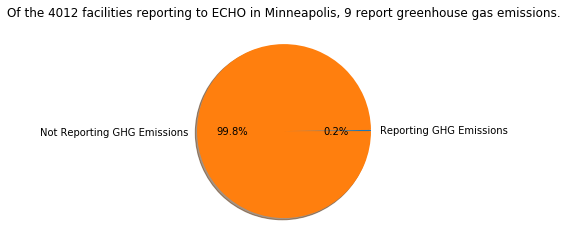

In [5]:
my_ghg = my_echo[my_echo["GHG_CO2_RELEASES"].notna()]

plt.pie([my_ghg.shape[0], num_facilities - my_ghg.shape[0]], labels=["Reporting GHG Emissions", "Not Reporting GHG Emissions"], autopct='%1.1f%%', shadow=True)

plt.title('Of the %s facilities reporting to ECHO in %s, %s report greenhouse gas emissions.' %(num_facilities, my_city, my_ghg.shape[0]))


Stats on CO2 releases for the facilities that are reporting: Total Facility Emissions in metric tons CO2e (excluding Biogenic CO2) from the most recent reporting year.

In [6]:
print("'Count' is the number of facilities reporting; all of the other numbers are statistics on the greenhouse gas emissions of all of the facilities in %s, measured in metric tons of CO2e." %my_city)
my_ghg["GHG_CO2_RELEASES"].describe()

'Count' is the number of facilities reporting; all of the other numbers are statistics on the greenhouse gas emissions of all of the facilities in Minneapolis, measured in metric tons of CO2e.


count         9.000000
mean     194459.444444
std      307656.828653
min       28139.000000
25%       53281.000000
50%       95382.000000
75%      150290.000000
max      999751.000000
Name: GHG_CO2_RELEASES, dtype: float64

In [7]:
# Let's show a quick map of your area and the facilities in it
# Generate a scale by which we can classify facilities , and map them accordingly
my_ghg["quartile"]=pd.qcut(my_ghg["GHG_CO2_RELEASES"], 4, labels=False, duplicates="drop") # quartiles
radii={0:6, 1:10, 2:14, 3: 20}

def mapper(dataframe):
    # Initialize the map
    m = folium.Map()

    # Add a clickable marker for each facility
    for index, row in dataframe.iterrows():
        folium.CircleMarker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"]+" released "+str("{:,.0f}".format(row["GHG_CO2_RELEASES"]))+" tons of GHG emissions last year.",
            radius = radii[row["quartile"]],
            color = "black",
            weight = 1,
            fill_color = "orange",
            fill_opacity= .4
        ).add_to(m)

    bounds = m.get_bounds()
    m.fit_bounds(bounds)
    
    # Show the map
    return m

map_of_facilities_in_my_area = mapper(my_ghg)
map_of_facilities_in_my_area

/Users/Eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## What's the cost of these emissions?
On May 25, 2020, George Floyd, a Black man, was killed by white Minneapolis, MN police offficer Derek Chauvin. Chauvin kneeled on Floyd's neck for nearly nine minutes, after arresting him for alledgly using a counterfeit $20 bill.

Every single day, the facilities mapped above release climate change-causing chemicals into the atmosphere - and they do so legally, in full public view (they report their numbers), and without reprcussion. 

The economic cost of these emissions can be calculated. The "social cost of carbon" is estimated to be about 50/ton. That is, every ton of GHG emitted represents a $50 cost to future generations, from rising sea levels that flood homes, strong storms that damage crops, and so on.

In [8]:
my_ghg=my_ghg.sort_values(by=['GHG_CO2_RELEASES'], ascending=False)
for index,row in my_ghg.iterrows():
    display(HTML("<h1>"+row[0]+"</h1>" + \
                "<h4>"+str("{:,.0f}".format(row[6]))+"</h3> tons of GHGs emitted last year." + \
                 "<h3> $"+str("{:,.0f}".format(row[6]*50))+"</h3> The amount of climate damage, done legally and in full public view. It amounts to an uncompensated theft from the future. " + \
                 "<h2>" +str("{:,.0f}".format((row[6]*50)/20))+" </h2> And that amount of money is this ^^^ many times more than the amount George Floyd was accused of counterfeiting."
                )
           )

## Clean Air Act violations

But that's not all. Every day around the country, companies release "criteria polluants" - pollutants that are so harmful to human health, EPA has special authority to regulate them. The Clean Air Act sets up a system whereby facilities are permitted to emit these chemicals, up to a certain point. But EPA doesn't even enforce these permitted levels on a regular basis. 

Here we chart "high priority" violations of limits on criteria pollutants and instances where facilities were forced to pay. Compare whether the violations track with enforcement actions, and whether the penalties seem fitting.

In [9]:
id_list = my_echo["AIR_IDS"].dropna()
ids=""
for id in id_list:
    ids+= "'"+id+"', "
ids = ids[0:len(ids)-2]

sql = "select * from `ICIS-AIR_VIOLATION_HISTORY` where pgm_sys_id in ("+ids+")"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

v_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
v_data.set_index("pgm_sys_id", inplace=True)

sql = "select * from `ICIS-AIR_FORMAL_ACTIONS` where pgm_sys_id in ("+ids+") and PENALTY_AMOUNT > 0"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

e_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
e_data.set_index("pgm_sys_id", inplace=True)

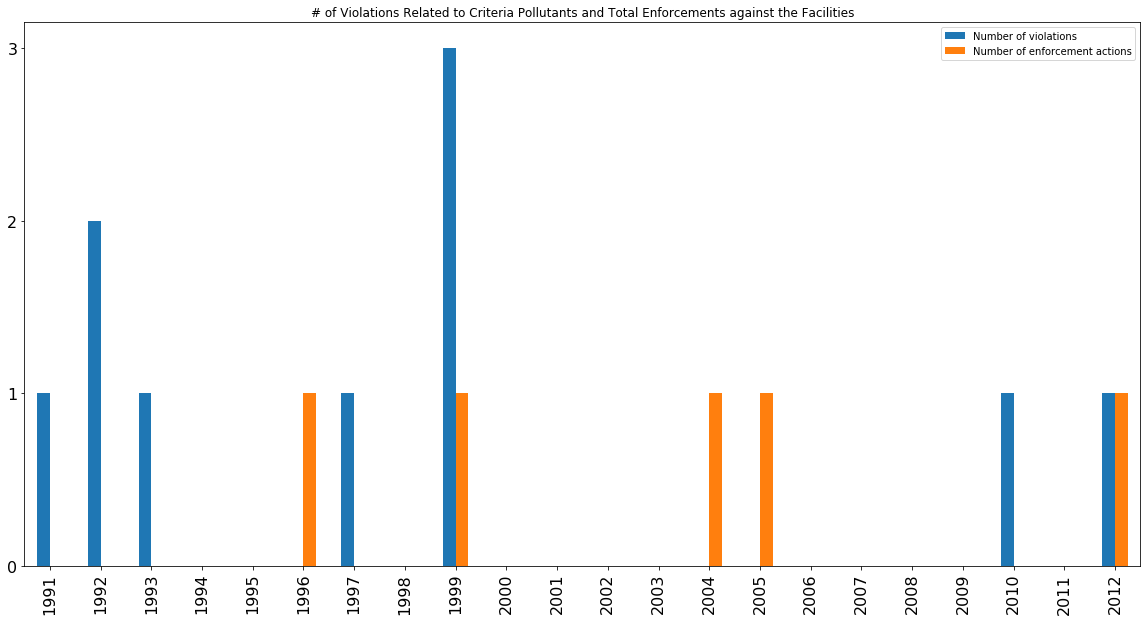

In [10]:
v_data['HPV_DAYZERO_DATE'] = pd.to_datetime(v_data['HPV_DAYZERO_DATE'], format="%m-%d-%Y") #format
e_data['SETTLEMENT_ENTERED_DATE'] = pd.to_datetime(e_data['SETTLEMENT_ENTERED_DATE'], format="%m/%d/%Y") #format
cps = v_data
e = e_data

cps = cps[(cps['POLLUTANT_DESCS'].astype(str).str.lower().str.contains('particulate')) | 
          (cps['POLLUTANT_DESCS'].astype(str).str.lower().str.contains('sulfur')) |
          (cps['POLLUTANT_DESCS'].astype(str).str.lower().str.contains('pm')) |
          (cps['POLLUTANT_DESCS'].astype(str).str.lower().str.contains('nox')) |
          (cps['POLLUTANT_DESCS'].astype(str).str.lower().str.contains('no2')) |
          (cps['POLLUTANT_DESCS'].astype(str).str.lower().str.contains('sox')) |
          (cps['POLLUTANT_DESCS'].astype(str).str.lower().str.contains('so2')) |
          (cps['POLLUTANT_DESCS'].astype(str).str.lower().str.contains('lead')) |
          (cps['POLLUTANT_DESCS'].astype(str).str.lower().str.contains('monoxide'))
         ]
facs = cps.index.unique() #facilities that violated CPs
f = e.index.isin(facs.tolist())
e = e[f]
s = e["PENALTY_AMOUNT"].sum() #total that facilities paid in penalties

cps = cps.groupby(['HPV_DAYZERO_DATE'])['POLLUTANT_DESCS'].count() 
e = e.groupby(['SETTLEMENT_ENTERED_DATE'])['ENF_TYPE_DESC'].count() 

cps = cps.resample('Y').sum() #resample to a yearly basis  
cps = pd.DataFrame(cps)
cps = cps.rename(columns={'POLLUTANT_DESCS': "Number of violations"})
cps.index = cps.index.strftime('%Y') # makes the x axis (date) prettier

e = e.resample('Y').sum() #resample to a yearly basis  
e = pd.DataFrame(e)
e = e.rename(columns={'ENF_TYPE_DESC': "Number of enforcement actions"})
e.index = e.index.strftime('%Y') # makes the x axis (date) prettier

d=cps.join(e)

ax = d.plot(kind='bar', title = "# of Violations Related to Criteria Pollutants and Total Enforcements against the Facilities", figsize=(20, 10), fontsize=16)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax

#facility name lookup
facs = facs.tolist()
f = my_echo["AIR_IDS"].isin(facs)
f = my_echo[f]

#print
display(HTML("<h1>$"+str("{:,.0f}".format(s))+"</h1>" + \
    "The following facilities/companies paid only this much in total for their violations."))
for index,row in f.iterrows():
    display(HTML("<h2> "+row[0]+"</h3>"))

## Next questions

What other questions would you like to see added? Here are some I have:
* What are the top 3 noncompliant facilities in the zip code and what are they violating?
* Which types of noncompliance are we experiencing here?
* Beyond "significant" – how much over their permits are they?

Please suggest questions (click "New Issue") on the [Github page for this project](https://github.com/edgi-govdata-archiving/ECHO-by-Zip-Code/issues). Maybe we can answer them together!
